In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal, osr
import matplotlib.pyplot as plt

# Définir les chemins des fichiers
raster_path = "../results/data/img_pretraitees/Serie_temp_S2_ndvi.tif"
shp_path = "../results/data/sample/Sample_BD_foret_T31TCJ.shp"
output_path = "../results/figure"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_path, "temp_mean_ndvi.png")

In [ ]:
# Charger le shapefile
gdf = gpd.read_file(shp_path)

# Filtrer pour ne conserver que les valeurs spécifiques
allowed_values = ["Chêne", "Robinier", "Peupleraie", "Douglas", "Pin laricio ou pin noir", "Pin maritime"]
gdf = gdf[gdf["Nom_pixel"].isin(allowed_values)]

# Obtenir le CRS du shapefile
shp_crs = gdf.crs

# Charger le raster
dataset = gdal.Open(raster_path)
raster_crs = osr.SpatialReference()
raster_crs.ImportFromWkt(dataset.GetProjection())

{'Douglas', 'Pin laricio ou pin noir', 'Robinier', 'Chêne', 'Peupleraie', 'Pin maritime'}


0

In [ ]:
# Reprojeter le raster pour correspondre au CRS du shapefile
def reproject_raster_to_match_shapefile(raster, target_crs, output):
    """Reproject a raster to match the CRS of a shapefile."""
    # Définir les paramètres pour la reprojection
    warp_options = gdal.WarpOptions(dstSRS=target_crs.to_wkt())
    # Effectuer la reprojection
    gdal.Warp(output, raster, options=warp_options)

# Chemin temporaire pour le raster reprojeté
reprojected_raster_path = "../results/data/img_pretraitees/Serie_temp_S2_ndvi_reprojected.tif"
reproject_raster_to_match_shapefile(dataset, shp_crs, reprojected_raster_path)

# Charger le raster reprojeté
reprojected_dataset = gdal.Open(reprojected_raster_path)
ndvi_stack = np.array([reprojected_dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(reprojected_dataset.RasterCount)])
transform = reprojected_dataset.GetGeoTransform()

# Calculer les centroïdes des géométries du shapefile
centroids = gdf.geometry.centroid  # Calculer les centroïdes
coords = [(centroid.x, centroid.y) for centroid in centroids]
nom_pixels = gdf['Nom_pixel']

# Convertir les coordonnées en indices de pixels
def world_to_pixel(transform, x, y):
    px = int((x - transform[0]) / transform[1])
    py = int((y - transform[3]) / transform[5])
    return px, py

pixel_indices = [world_to_pixel(transform, x, y) for x, y in coords]

# Vérifier les indices des pixels et filtrer ceux qui sont hors des limites du raster
valid_pixel_indices = []
valid_nom_pixels = []

for name, (row, col) in zip(nom_pixels, pixel_indices):
    if 0 <= row < ndvi_stack.shape[1] and 0 <= col < ndvi_stack.shape[2]:
        valid_pixel_indices.append((row, col))
        valid_nom_pixels.append(name)

# Extraire les valeurs NDVI uniquement pour les pixels valides
ndvi_values = {
    name: ndvi_stack[:, row, col] for name, (row, col) in zip(valid_nom_pixels, valid_pixel_indices)
}

# Calculer la moyenne et l'écart type par bande
df = pd.DataFrame(ndvi_values)
ndvi_mean = df.mean(axis=1)
ndvi_std = df.std(axis=1)

0    0.087923
1    0.096272
2    0.142969
3    0.141863
4    0.137968
5    0.082905
dtype: float32


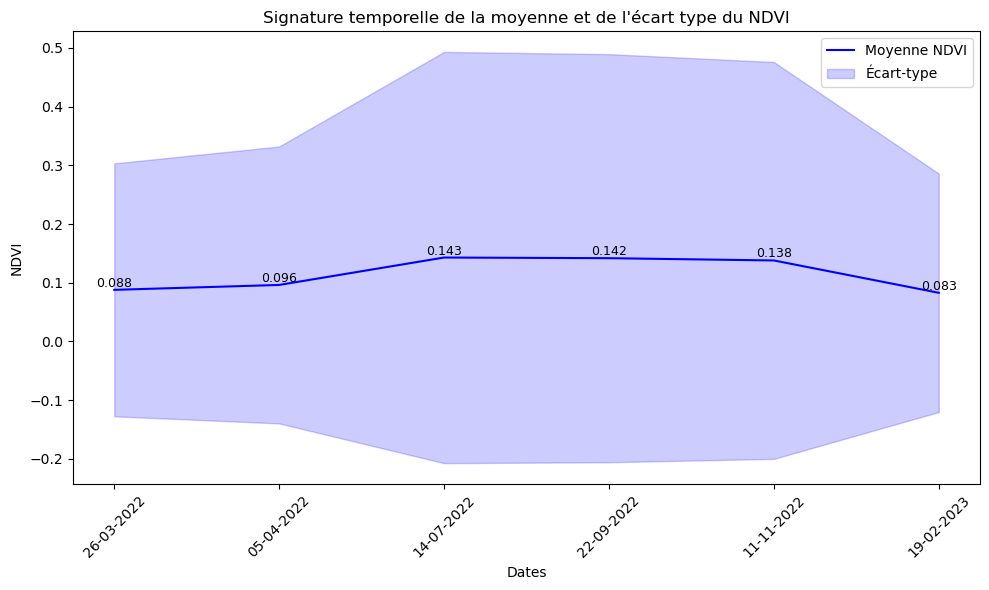

Graphique sauvegardé : ../results/figure/temp_mean_ndvi.png


In [36]:
dates = [
    "26-03-2022", "05-04-2022", "14-07-2022", "22-09-2022", "11-11-2022", "19-02-2023"
]

# Créer un graphique avec Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(len(ndvi_mean)), ndvi_mean, label='Moyenne NDVI', color='blue')
plt.fill_between(
    range(len(ndvi_mean)),
    ndvi_mean - ndvi_std,
    ndvi_mean + ndvi_std,
    color='blue', alpha=0.2, label="Écart-type"
)

for i, value in enumerate(ndvi_mean):
    plt.text(i, value, f"{value:.3f}", ha='center', va='bottom', fontsize=9, color='black')

# Personnalisation du graphique
plt.title("Signature temporelle de la moyenne et de l'écart type du NDVI")
plt.xlabel("Dates")
plt.ylabel("NDVI")
plt.xticks(ticks=range(len(dates)), labels=dates, rotation=45)  # Utilisation des dates comme étiquettes
plt.legend(loc='upper right')

# Sauvegarder et afficher le graphique
plt.tight_layout()
plt.savefig(output_file)
plt.show()

print(f"Graphique sauvegardé : {output_file}")

In [37]:
os.remove(reprojected_raster_path)